# P3: OpenStreetMap Data Case Study. Moscow Region

### 0.1. Code Library

In [1]:
from ipykernel import kernelapp as app

In [2]:
from IPython.core.display import display, HTML

In [3]:
import matplotlib

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
import folium

In [7]:
import geopandas as gpd

In [8]:
from mpl_toolkits.basemap import Basemap

In [9]:
import xml.etree.cElementTree as ET

In [10]:
from collections import defaultdict as dfdict

In [11]:
import numpy as np

In [12]:
import pprint

In [13]:
import urllib

In [14]:
import re

In [15]:
import os

In [16]:
import csv

In [17]:
import cerberus

In [18]:
import json

In [19]:
import codecs

In [20]:
import signal
import subprocess
pro = subprocess.Popen('mongod', preexec_fn = os.setsid)

In [21]:
from pymongo import MongoClient

db_name = 'openstreetmap'

# Connect to Mongo DB
client = MongoClient('localhost:27017')
db = client[db_name]

In [22]:
from IPython.display import Image

In [23]:
import collections

In [24]:
import sqlite3

In [25]:
import geopandas.io

In [26]:
from sqlalchemy import create_engine

In [27]:
import pandas as pd

In [28]:
import io

### 0.2. Useful links

https://wiki.openstreetmap.org/wiki/OSM_XML

http://learnosm.org/en/osm-data/getting-data/#downloading-data-extracts

https://mapzen.com/data/metro-extracts/

http://python-visualization.github.io/folium/quickstart.html

http://geopandas.org/mapping.html

https://borealperspectives.wordpress.com/2016/03/07/plotting-polygon-shapefiles-on-a-matplotlib-basemap-with-geopandas-shapely-and-descartes/

http://maxberggren.se/2015/08/04/basemap/

http://api.mongodb.com/python/current/tutorial.html

https://docs.mongodb.com/manual/reference/operator/query/

### 0.3. Code for Researching the Imported Files and Creating the Data.

##### Сode snippets of the courses "Intro to Relational Databases", "Data Wrangling with MongoDB" (udacity.com) have been used here.

In [29]:
# Function for counting tags
def count_tags(filename):
    count = dfdict(int)
    for item in ET.iterparse(filename):
        count[item[1].tag] += 1
    return count

In [30]:
# Functions for counting users
def get_user(element):
    return

def process_map_users(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        if element.tag == 'node' or element.tag == 'way' or element.tag == 'relation':
            users.add(element.attrib['user'])

    return users

In [31]:
# Strings containing lower case chars
lower = re.compile(r'^([a-z]|_)*$') 
# Strings with lower case chars and a ':'
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
# Strings with chars that will cause problems as keys. 
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')  

# Function for sorting by key type
def key_type(element, keys):
    if element.tag == "tag":

            if lower.search(element.attrib['k']) != None: 
                keys['lower'] += 1
            elif lower_colon.search(element.attrib['k']) != None:
                keys['lower_colon'] += 1
            elif problemchars.search(element.attrib['k']) != None:
                keys['problemchars'] += 1
            else: 
                keys['other'] += 1

    return keys

# Function for counting keys by type
def process_map_keys(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

In [61]:
# Function for counting address attributes by type
def address_attribute(filename):
    address_attributes={}
    for event, elem in ET.iterparse(filename):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if re.search(re.compile("addr:.*$"),tag.get("k")):
                    if tag.get("k") in address_attributes:
                        address_attributes[tag.get("k")]+=1
                    else:
                        address_attributes[tag.get("k")]=1
    return address_attributes

In [32]:
# Function for counting street addresses
def street_number(file_name):
    count = 0

    for event, elem in ET.iterparse(file_name, events=("start",)):
        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                if tag.attrib['k'] == "addr:street":
                    count += 1
    return count

In [33]:
# Function for counting zip codes.
def zip_codes(filename):
    count = 0
    data = set()

    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                if tag.attrib['k'] == "addr:postcode":
                    count += 1
                    data.add( tag.attrib['v'] )
                                     
    return count, data

In [57]:
# Functions for auditing zip codes
expected=list(range(140000,143000) + range(144000, 145000) + range(600000, 603000))
expected=map(str, expected)

def audit_postcode_range(postcode, wrong_postcode, tag):
    if tag.attrib["v"] in expected:
        if tag.attrib["v"] not in postcode:
            postcode[tag.attrib["v"]]=1
        else:
            postcode[tag.attrib["v"]]+=1 
    else:
        if tag.attrib["v"] not in wrong_postcode:
            wrong_postcode[tag.attrib["v"]]=1
        else:
            wrong_postcode[tag.attrib["v"]]+=1 
            
def is_postcode(elem):
    return (elem.attrib['k'] == "addr:postcode")

def process_map_postcodes(filename):
    postcode={}
    wrong_postcode={}
    osm_file = open(filename, "r")
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_postcode(tag):
                    audit_postcode_range(postcode, wrong_postcode, tag)
    return postcode, wrong_postcode   

In [63]:
# Functions for correction zip codes
def update_postcode(tag):
    tag.attrib["v"]=None
    return tag
def correct_postcode(filename):
    osm_file = open(filename, "r")
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_postcode(tag) and tag.attrib["v"] == 'RU':
                    update_postcode(tag)

In [35]:
# Function for displaying english names
def process_map_names(filename):
    count = 0
    data = set()

    for event, elem in ET.iterparse(filename, events=("start",)):
        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                if tag.attrib['k'] == "name:en":
                    count += 1
                    data.add( tag.attrib['v'] )
                                     
    return count, data 

In [36]:
# Function for sorting by place
def place_type(element, places):
    if element.tag == "node":
         for tag in element.iter('tag'):
                if tag.attrib['k'] == 'place':
                    if tag.attrib['v'] == 'city': 
                        places['city'] += 1
                    elif tag.attrib['v'] == 'town':
                        places['town'] += 1
                    elif tag.attrib['v'] == 'village':
                        places['village'] += 1
                    elif tag.attrib['v'] == 'hamlet':
                        places['hamlet'] += 1
                    else: 
                        places['other'] += 1
                        
    return places

# Function for counting places by type
def process_map_places(filename):
    places = {"city": 0, "town": 0, "village": 0, "hamlet" : 0, "other": 0}
    for _, element in ET.iterparse(filename):
        places = place_type(element, places)

    return places

In [37]:
# Functions for creating the sample file
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

In [39]:
# Schema for validating elements
schema1 = {
    'node': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string', 'required': True}
            }
        }
    }
}


In [162]:
LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['changeset', 'id', 'timestamp', 'uid', 'user', 'version']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS, 
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    if element.tag == 'node':
        node_attributes = {}    
        tags = []
        
        for unit in NODE_FIELDS:
            node_attributes[unit] = element.attrib[unit]

        for tag in element.iter('tag'):  
 
            problem = PROBLEMCHARS.search(tag.attrib['k'])

            if not problem:
                node_tag_dictionary = {} 
                node_tag_dictionary['id'] = element.attrib['id'] 
                node_tag_dictionary['value'] = tag.attrib['v']  

                point = LOWER_COLON.search(tag.attrib['k'])
                if not point:
                    node_tag_dictionary['type'] = 'regular'
                    node_tag_dictionary['key'] = tag.attrib['k']
                else:
                    before = re.findall('^(.+):', tag.attrib['k'])
                    after = re.findall('^[a-z]+:(.+)', tag.attrib['k'])

                    node_tag_dictionary['type'] = before[0]
                    node_tag_dictionary['key'] = after[0]

            tags.append(node_tag_dictionary)
        
        return {'node': node_attributes, 'node_tags': tags}
    
    elif element.tag == 'way':
        way_attributes = {}
        way_nodes = []
        tags = []  
    
        for unit in WAY_FIELDS:
            way_attributes[unit] = element.attrib[unit]
    
        for tag in element.iter('tag'):  
 
            problem = PROBLEMCHARS.search(tag.attrib['k'])
            if not problem:
                way_tag_dictionary = {}
                way_tag_dictionary['id'] = element.attrib['id'] 
                way_tag_dictionary['value'] = tag.attrib['v']  

                point = LOWER_COLON.search(tag.attrib['k'])
                if not point:
                    way_tag_dictionary['type'] = 'regular'
                    way_tag_dictionary['key'] = tag.attrib['k']
                else:
                    before = re.findall('^(.+):', tag.attrib['k'])
                    after = re.findall('^[a-z]+:(.+)', tag.attrib['k'])

                    way_tag_dictionary['type'] = before[0]
                    way_tag_dictionary['key'] = after[0]

            tags.append(way_tag_dictionary)
    
        for tag in element.iter("nd"):  
            way_nd_dictionary = {} 
            count = 0
            way_nd_dictionary['id'] = element.attrib['id'] 
            way_nd_dictionary['node_id'] = tag.attrib['ref'] 
            way_nd_dictionary['position'] = count  
            count += 1
            
            way_nodes.append(way_nd_dictionary)
    
        return {'way': way_attributes, 'way_nodes': way_nodes, 'way_tags': tags}
# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=schema1):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_strings = (
            "{0}: {1}".format(k, v if isinstance(v, str) else ", ".join(v))
            for k, v in errors.iteritems()
        )
        raise cerberus.ValidationError(
            message_string.format(field, "\n".join(error_strings))
        )


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map_csv(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
        codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
        codecs.open(WAYS_PATH, 'w') as ways_file, \
        codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
        codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


# if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.

In [163]:
# Strings containing lower case chars
lower = re.compile(r'^([a-z]|_)*$')
# Strings with lower case chars and a ':'
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
# Strings with chars that will cause problems as keys.
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

def shape_element(element):
    node = {}
    if element.tag == "node" or element.tag == "way":
        address = {}
        nd = []
        node["type"] = element.tag
        node["id"] = element.attrib["id"]
        if "visible" in element.attrib.keys():
            node["visible"] = element.attrib["visible"]
        if "lat" in element.attrib.keys():
            node["pos"] = [float(element.attrib['lat']), float(element.attrib['lon'])]
        node["created"] = {"version": element.attrib['version'],
                            "changeset": element.attrib['changeset'],
                            "timestamp": element.attrib['timestamp'],
                            "uid": element.attrib['uid'],
                            "user": element.attrib['user']}
        for tag in element.iter("tag"):
            p = problemchars.search(tag.attrib['k'])
            if p:
                print "problemchars: ", p.group()
                continue
            elif tag.attrib['k'][:5] == "addr:":
                if ":" in tag.attrib['k'][5:]:
                    continue
                else:
                    address[tag.attrib['k'][5:]] = tag.attrib['v']
            else:
                node[tag.attrib['k']] = tag.attrib['v']
        if address != {}:
            node['address'] = address
        for tag2 in element.iter("nd"):
            nd.append(tag2.attrib['ref'])
        if nd != []:
            node['node_refs'] = nd
        return node
    else:
        return None
    
# Function for creating the .json file
def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

### 1. Map Area

#### 1.1.  The map
##### I have chosed the map sector of the dynamically developing area in the Moscow region, Russia.
##### For displaying the area I have used the  package "folium" and the coordinates of this area in moscow_region.osm.

In [38]:
# Display the coordinates of bounds from .osm file
HTML('<h4>bounds minlat="55.5037498" minlon="38.3944702" maxlat="56.1011515" maxlon="39.5617675"</h4>')

In [45]:
# Setup the coordinates of the map center and the zoom option.
map_osm = folium.Map(location=[55.7986, 38.9754], zoom_start=9)
# Add labels with coordinates.
folium.LatLngPopup().add_to(map_osm)
# Setup the coordinates of the map area.
points=[[55.5037, 38.3945], [55.5037, 39.5618], [56.1012, 39.5618], [56.1012, 38.3945], [55.5037, 38.3945]]
# Setup the border line with options.
folium.PolyLine(points, color="red", weight=5, opacity=0.3).add_to(map_osm)
# Display the map.
map_osm

##### 1.2 Extract with Python
##### There are several ways to extract geodata. One of them is to do this with this python code cell.

In [166]:
# Extract from overpass-api.de
file00 = urllib.URLopener()
file00.retrieve("http://overpass-api.de/api/map? bbox=38.3945,55.5037,39.5618,56.1012", "moscow_region0.osm")

('moscow_region0.osm', <httplib.HTTPMessage instance at 0x198052d40>)

##### 1.3 Extract from OpenStreetMaps.org

##### Another possible way is extracting data files in many different formats from the website: 
https://mapzen.com/data/metro-extracts/ .
##### The files moscow_region.osm, moscow_region_buildings.geojson, etc.  were downloaded.

#### 1.4. Size of downloaded files.

In [40]:
# Setup file directories and names of file variables
filedir1 = '/Users/olgabelitskaya/large-repo/'
filedir2 = '/Users/olgabelitskaya/large-repo/moscow_region.imposm-geojson/'
filedir3 = '/Users/olgabelitskaya/large-repo/moscow_region.imposm-shapefiles/'
file0 = filedir1 + 'moscow_region0.osm'
file1 = filedir1 + 'moscow_region.osm'
file2 = filedir2 + 'moscow_region_admin.geojson'
file3 = filedir2 + 'moscow_region_roads.geojson'
file4 = filedir2 + 'moscow_region_waterareas.geojson'

In [46]:
# Get size of the .osm files
os.path.getsize(file0)

251766924

In [47]:
os.path.getsize(file1)

239613812

In [48]:
# Get size of the .geojson files
os.path.getsize(file2)

418743

In [49]:
os.path.getsize(file3)

20282370

In [50]:
os.path.getsize(file4)

3727423

##### 1.5 Osm files

##### This is not so large piece of data to process (239,6 MB) in the moscow_region .osm file and for me it is a very interesting subject for reseach because of many reasons.
##### For example, it is a constant changing territory and there is my hometown here.
##### Applying the special function (§ 0.3) I created the sample.osm file from the moscow_region .osm file.

In [164]:
# Setup the file for sample extraction
OSM_FILE = file1 
# Setup the name for the file with a sample
SAMPLE_FILE = "sample.osm"

In [ ]:
# Create a sample file
k = 100 # Parameter: take every k-th top level element

with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')

In [48]:
# Setup the file directory and the name of a file variable
file5 = filedir1 + 'sample.osm'

In [49]:
# Get size of the created .osm file
os.path.getsize(file5)

2425559

#### 1.6 Geojson files
##### It's possible to download from OpenStreetMap several type of files: .osm, .geojson, etc.
##### For displaying the data in .geojson files the  package "geopandas" also can be useful. As an example you can see the map of administrative borders, roads and water areas.

In [53]:
# Read the .geojson files
df_admin = gpd.read_file(file2)

In [54]:
df_roads = gpd.read_file(file3)

In [55]:
df_waterareas = gpd.read_file(file4)

In [56]:
# Get the dimensionality of the data
df_admin.shape

(33, 6)

In [57]:
df_roads.shape

(29606, 13)

In [58]:
df_waterareas.shape

(3297, 6)

In [59]:
# Display examples of data rows
df_admin.head(3)

admin_leve                                           geometry  id  \
0           6  POLYGON ((38.86624409386252 55.95457384334551,...   1   
1           6  POLYGON ((38.47872121750854 55.67355662549416,...   2   
2           6  POLYGON ((38.91638673412226 55.78961756979561,...   3   

                      name  osm_id            type  
0         Киржачский район -389662  administrative  
1  Павлово-Посадский район -179639  administrative  
2   Орехово-Зуевский район -179640  administrative

In [60]:
df_roads.head(3)

access  bridge    class                                           geometry  \
0   None       0  highway  LINESTRING (38.95197663027312 55.6939924598025...   
1   None       0  highway  LINESTRING (38.96006248462654 55.6965672966383...   
2   None       1  highway  LINESTRING (38.41803548416101 55.7222471848481...   

   id                  name  oneway    osm_id    ref service  tunnel  \
0   1  5-й проезд 1905 года       0  20272228   None    None       0   
1   2  улица 40 лет Октября       0  20272232   None    None       0   
2   3                  None       0   8654633  А-107    None       0   

          type  z_order  
0  residential        3  
1     tertiary        4  
2        trunk       28

In [61]:
df_waterareas.head(3)

area                                           geometry  id  \
0  0.000001  POLYGON ((39.12234895437766 55.55916828997104,...   1   
1  0.000001  POLYGON ((38.9839863641215 55.80269099181339, ...   2   
2  0.000020  POLYGON ((38.97600444536743 55.7738939576324, ...   3   

               name  osm_id   type  
0            Зайчик -254933  water  
1  Морозовский пруд -366434  water  
2   Казанское озеро -364755  water

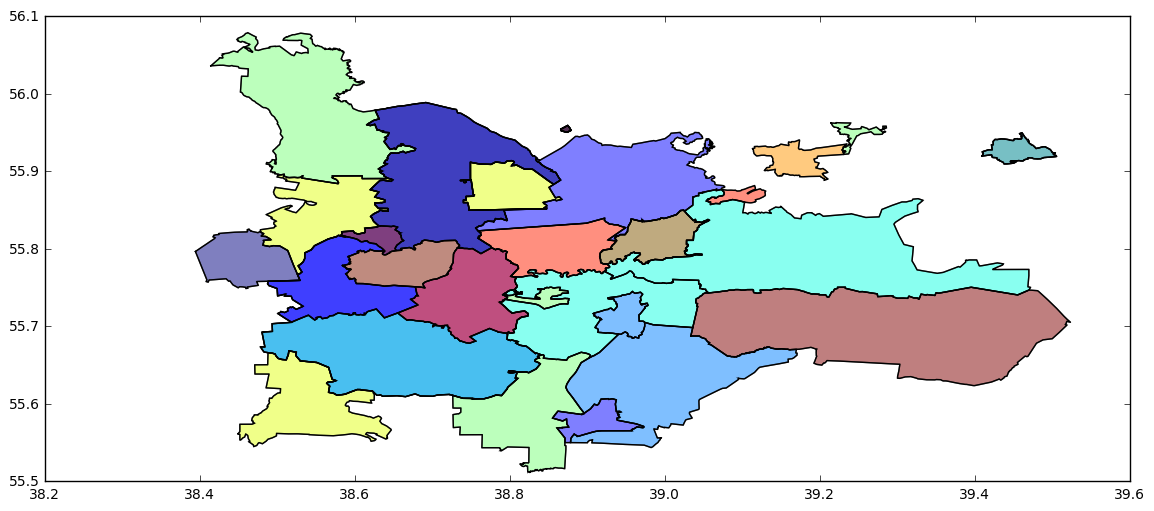

In [62]:
# Setup the size of the image
# matplotlib.rcParams['figure.figsize'] = (14, 14)
plt.figure(figsize=(14,14))
# Print map
df_admin.plot()
plt.show()

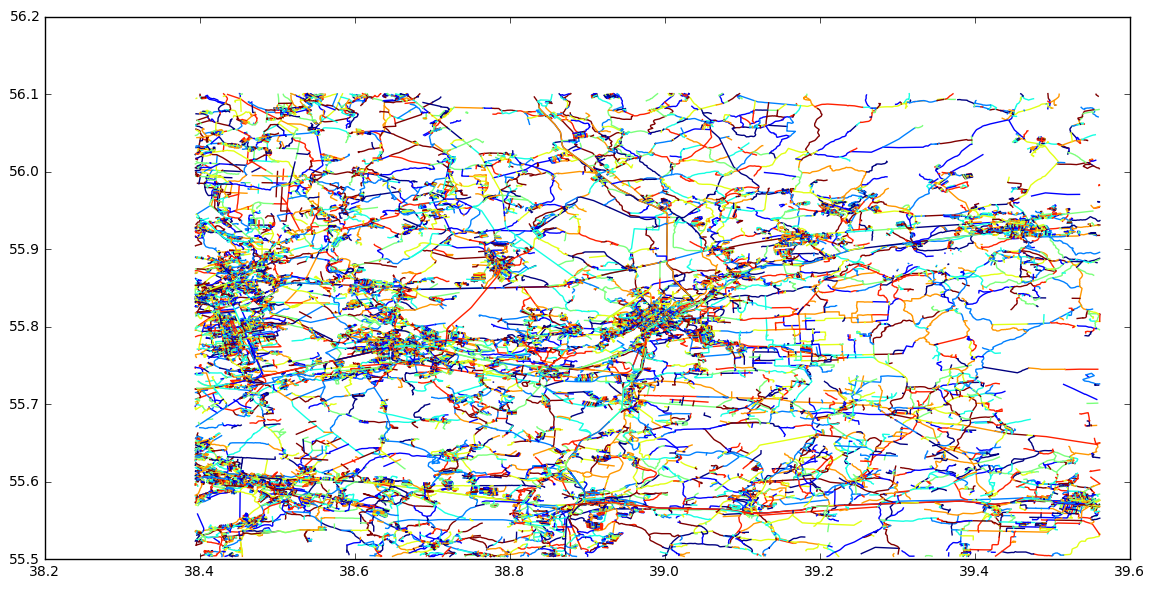

In [63]:
plt.figure(figsize=(14,14))
df_roads.plot()
plt.show()

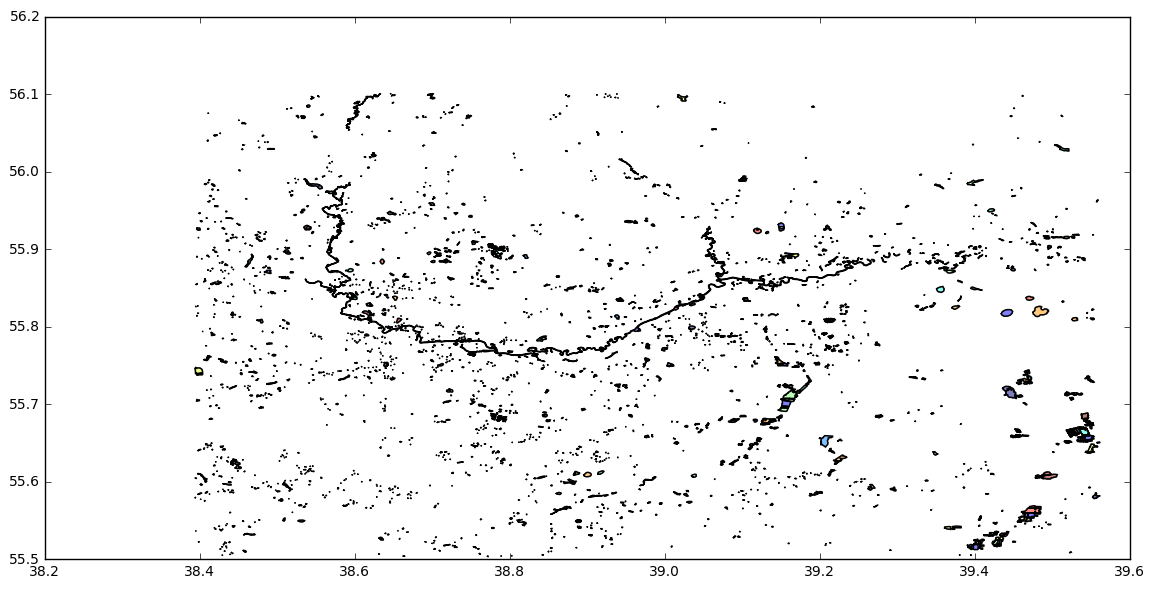

In [64]:
plt.figure(figsize=(14,14))
df_waterareas.plot()
plt.show()

##### 1.7 Shapefiles

##### For displaying the data in shapefiles it's possible to apply the package "basemap". As an example you can see the map of administrative borders, roads and water areas.

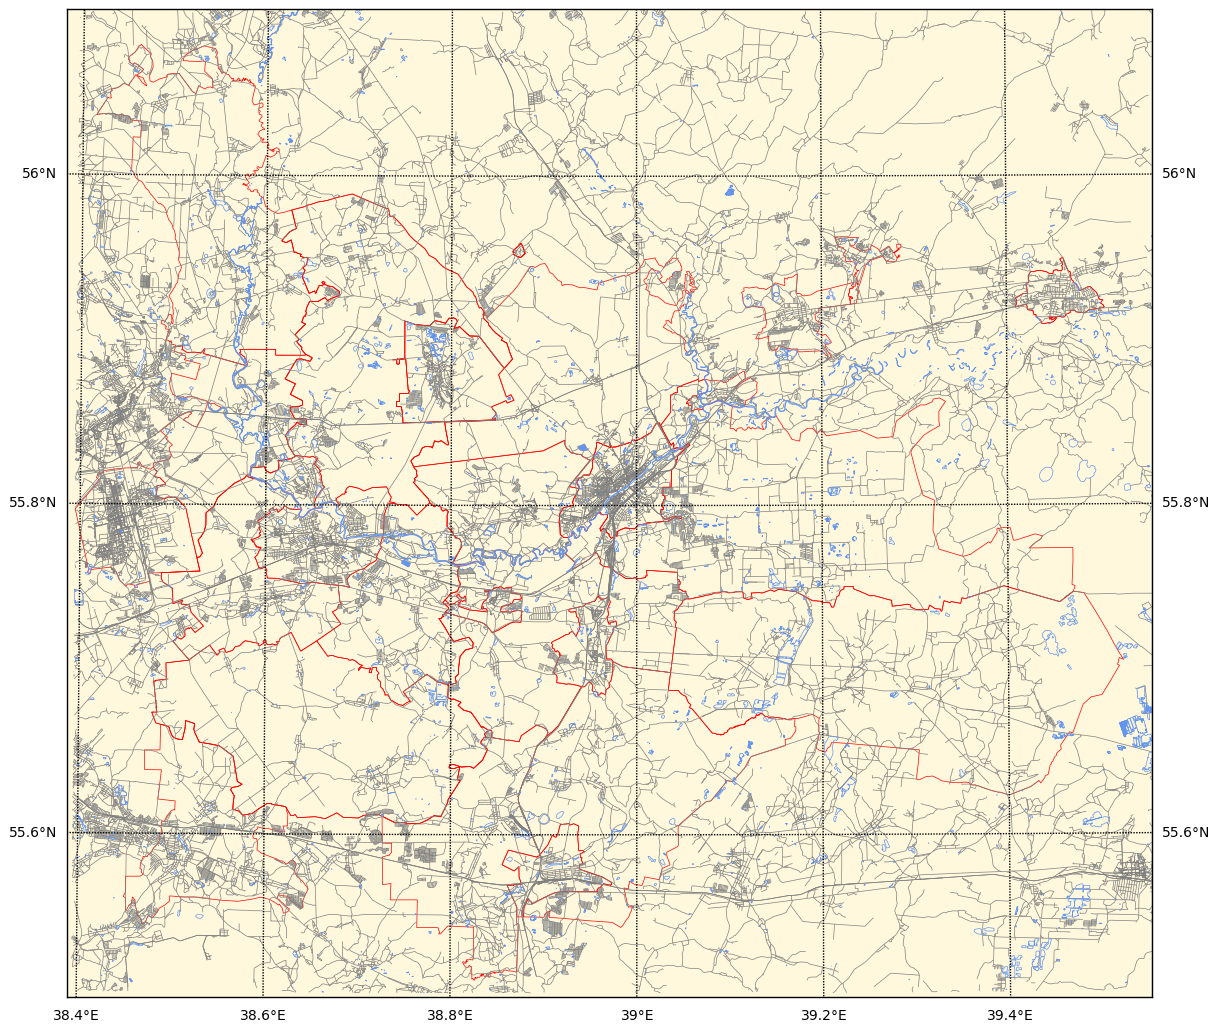

In [65]:
# Setup the size of the image
plt.figure(figsize=(14,14))
# Setup the colors for surfaces
water = 'lightskyblue'
earth = 'cornsilk'
# Create a map
mm = Basemap(llcrnrlon=38.39, llcrnrlat=55.50, urcrnrlon=39.56, urcrnrlat=56.10, 
             ellps='WGS84', resolution='i', projection='cass', lat_0 = 55.7986, lon_0 = 38.9754)
# Variables for drawing map components
coast = mm.drawcoastlines()
rivers = mm.drawrivers(color=water, linewidth=1)
continents = mm.fillcontinents(color=earth,lake_color=water)
bound= mm.drawmapboundary(fill_color=water)
countries = mm.drawcountries()
merid = mm.drawmeridians(np.arange(-180, 180, 0.2), labels=[False, False, False, True])
parall = mm.drawparallels(np.arange(0, 80, 0.2), labels=[True, True, False, False])
# Read shapefiles
mm.readshapefile('/Users/olgabelitskaya/large-repo/moscow_region.imposm-shapefiles/moscow_region_osm_admin', 
                 name='admin', drawbounds=True, color='red')
mm.readshapefile('/Users/olgabelitskaya/large-repo/moscow_region.imposm-shapefiles/moscow_region_osm_roads', 
                 name='roads', drawbounds=True, color='grey')
mm.readshapefile('/Users/olgabelitskaya/large-repo/moscow_region.imposm-shapefiles/moscow_region_osm_waterareas', 
                 name='waterareas', drawbounds=True, color='cornflowerblue')
# Display the map
plt.show()

##### 1.8 CSV files

##### Applying the special function (§ 0.3) I created the csv files from the sample.osm the moscow_region.osm.

In [83]:
# Setup variables for extracting csv files (sample)
OSM_PATH = file5

NODES_PATH = "nodes0.csv"
NODE_TAGS_PATH = "nodes_tags0.csv"
WAYS_PATH = "ways0.csv"
WAY_NODES_PATH = "ways_nodes0.csv"
WAY_TAGS_PATH = "ways_tags0.csv"

In [170]:
# Extract data from sample.osm as csv files
# process_map_csv(OSM_PATH, validate=True)

In [85]:
# Setup variables for extracting csv files (dataset)
OSM_PATH = file1

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

In [169]:
# Extract data from the dataset in the .osm format as csv files
# process_map_csv(OSM_PATH, validate=False)

##### 1.9 Json file

##### Applying the special function (§ 0.3) I created the moscow_region.osm.json from the moscow_region.osm file.

In [171]:
# Extract data from the dataset in the .osm format as json files
data1 = process_map(file1)

In [52]:
# Setup the variable for the .json file
file7 = filedir1 + 'moscow_region.osm.json'

In [53]:
# Get size of the .json file
os.path.getsize(file7)

281607059

### 2. Data (OSM)

##### Let's discover the data in .osm files in details.

##### 2.1 Tags

In [91]:
# Count tags
count_tags(file1)

defaultdict(int,
            {'bounds': 1,
             'member': 12002,
             'nd': 1451696,
             'node': 1120539,
             'osm': 1,
             'relation': 2286,
             'tag': 264103,
             'way': 162947})

##### 2.2 Users

In [65]:
# Count users of the map editing
users1 = process_map_users(file1)

In [77]:
# Display number of users
print "Number of users -", len(users1)
# Display example of the user list
user_list = list(users1)
print sorted(user_list)[:50]

Number of users - 681
['347929', '3akep', '3axapm', '3ton', '4530787', '4euro', '50on50', '5Nap', '8simbols', 'AKz', 'AMDmi3', 'AVB543', 'Aas79gv', 'AdventurerRussia', 'Alastor', 'Alchi', 'Aleksandr Dezhin', 'AlexGord', 'AlexKu7808', 'AlexTheTux', 'Alexander Deynichenko', 'Alexander Leschinsky', 'Alexandr Zeinalov', 'Alexandr55', 'Alexcey88', 'Alexey Guseynov', 'AlexeyKucherenko', 'AlexeyS', 'AlexeySh', 'Allexnew', 'Alselt', 'Amigo', 'AndiG88', 'Andrey Chichak', 'Andrey Vlchev', 'Andronik Fa', 'Andy_sv', 'Angrycat', 'Angrysquid', 'Ant493', 'Antivirus91', 'Anton Belkin', 'AntonAK', 'Antony_k', 'Apoh4eg', 'ArPaHoMs', 'Ardiscad', 'Atakua', 'Autmn', 'Autoplus']


##### 2.3 Keys

In [149]:
# Count keys by types
process_map_keys(file1)

{'lower': 223976, 'lower_colon': 39687, 'other': 251, 'problemchars': 189}

##### 2.4 Address attributes & number of street addresses

In [62]:
# Count address attributes by type
address_attribute(file1)

{'addr:city': 3938,
 'addr:country': 3076,
 'addr:district': 649,
 'addr:hamlet': 1,
 'addr:housename': 12,
 'addr:housenumber': 6903,
 'addr:housenumber2': 5,
 'addr:interpolation': 1,
 'addr:neighbourhood': 3,
 'addr:place': 621,
 'addr:postcode': 1544,
 'addr:region': 643,
 'addr:street': 6874,
 'addr:subdistrict': 1}

In [97]:
# Count street addresses
street_number(file1)

6746

##### 2.5 Places

In [148]:
# Count places by types
process_map_places(file1)

{'city': 3, 'hamlet': 298, 'other': 63, 'town': 13, 'village': 130}

##### 2.6 Names in English

In [114]:
# Count names in english with values
english_names1 = process_map_names(file1)

In [122]:
# Display english names
print english_names1

(78, set(['Fryazevo', 'Elektrostal', 'Shaturtorf', 'Fenino', 'Pavlovsky Posad', 'Gorki', 'Staroye Titovo', 'Sanino', '821th Main Space Intelligence Centre', 'Selivanikha', 'Ponarino', 'Gzhel', 'Guslitsa', 'Gzhelskogo kirpichnogo zavoda', 'Konyashino', 'Troshkovo', 'Avsyunino', 'Saputnoye', 'Minino', 'Likino-Dulyovo', "McDonald's", 'Pokrov', 'Elektrogorsk', 'Orekhovo-Zuevo', 'Chernogolovka', 'Drezna', 'Fomino', 'Svorkovo', 'Avsjunino', 'Znamya', 'Gorbuny', 'Noginsk', 'Circle K', 'Znamenskoye', 'Gribanino', 'Petrushino', 'Road to Belyvsiye Skity', 'Ignatyevo', 'Petushki', 'Rodionovo', 'derevnya Dorokhovo', 'Glebovo', 'Dvornikovo', 'Subway', 'Davydovo', 'Krupino', 'Magnit', 'Kalitino', 'Fryazevo Railway Station', '55 km', 'Petrovskoye', 'Dubrovo', 'Shatura', 'Novoye Titovo', 'Levoshevo', 'Framing workshop, Art salon "Manufactura"', 'Kuzyayevo', 'Kurovskoye', 'Koreshkova street', 'Zhilino', 'Mistsevo', 'Krasnyy Luch']))


##### On the map we can find the names in English. As you can see, they are not only the names of settlements but also the names of infrastructure objects. The next obvious conclusion about it: not all the cities, towns, hamlets and villages on the map have names in English.

##### 2.7 Postal Codes

In [121]:
# Display zip codes
print zip_codes(file1)

(1503, set(['142436', '142515', '142516', '142432', '142411', '142670', '142602', '142438', '142439', '142620', '142530', 'RU', '142672', '140165', '140145', '144000', '140703', '142641', '142502', '142640', '142642', '142645', '142409', '142621', '142646', '142649', '601130', '601010', '142612', '142664', '144005', '142608', '142613', '144004', '140221', '601143', '142601', '142600', '142603', '140712', '142520', '142507', '142504', '142505', '144009', '140704', '142500', '142408', '142542', '144001', '144007', '142541', '142403', '142402', '142401', '142400', '142605', '142660', '144010', '144002', '144006', '140150', '601144', '140155', '601103', '142651', '142647', '601105', '601125', '601127', '601120', '142671', '601122', '601123', '142407', '142663', '142636', '142506', '142631', '142632', '142633', '601109', '142635', '140700', '142611']))


###### According to reference information (https://en.wikipedia.org/wiki/List_of_postal_codes_in_Russia) the postal codes for Moscow Region begin with 140, 141, 142, 144, for Vladimir region - with 600, 601, 602. This section of map is located on the territory of these two regions.

In [59]:
# Audit zip codes
postcode1, wrong_postcode1 = process_map_postcodes(file1)

In [60]:
# Display number of unexpected zip codes
wrong_postcode1

{'RU': 12}

###### There are 1503​ notations in the dataset and 12 of them with wrong postcodes. 

In [64]:
correct_postcode(file1)

In [65]:
postcode1, wrong_postcode1 = process_map_postcodes(file1)

In [66]:
wrong_postcode1

{'RU': 12}

### 3. JSON & Mongo DB

##### 3.1 Database

In [55]:
# Build mongoimport command 
collection = file1[:file1.find('.')]
mongoimport_cmd = 'mongoimport -h 127.0.0.1:27017 ' + '--db ' + db_name + \
                  ' --collection ' + collection + ' --file ' + file7

# Drop collection (if it's already running) 
if collection in db.collection_names():
    print 'Dropping collection: ' + collection
    db[collection].drop()
    
# Execute the command
print 'Executing: ' + mongoimport_cmd
subprocess.call(mongoimport_cmd.split())

Executing: mongoimport -h 127.0.0.1:27017 --db openstreetmap --collection /Users/olgabelitskaya/large-repo/moscow_region --file /Users/olgabelitskaya/large-repo/moscow_region.osm.json


0

In [56]:
# Create mongo db
moscow_region = db[collection]

##### 3.2 Indicators

In [84]:
# Display an example of documents
moscow_region.find_one()

{u'_id': ObjectId('57f15e5164676f9dd941fd0b'),
 u'created': {u'changeset': u'27649404',
  u'timestamp': u'2014-12-23T12:20:48Z',
  u'uid': u'342091',
  u'user': u'giskarta',
  u'version': u'6'},
 u'id': u'61714577',
 u'pos': [55.9315049, 38.4021196],
 u'type': u'node'}

In [57]:
# Count documents
moscow_region.find().count()

1283486

In [59]:
# Count nodes
moscow_region.find({'type':'node'}).count()

1120531

In [60]:
# Count ways
moscow_region.find({'type':'way'}).count()

162924

##### 3.3 Users

In [69]:
# Count users
len(moscow_region.distinct('created.user'))

667

In [76]:
# Create list of users
user_list_mongo = moscow_region.distinct('created.user')
# Display some user names
print sorted(user_list_mongo)[:50]

[u'347929', u'3akep', u'3axapm', u'3ton', u'4530787', u'4euro', u'50on50', u'5Nap', u'8simbols', u'AKz', u'AMDmi3', u'AVB543', u'Aas79gv', u'AdventurerRussia', u'Alastor', u'Alchi', u'Aleksandr Dezhin', u'AlexGord', u'AlexKu7808', u'AlexTheTux', u'Alexander Deynichenko', u'Alexander Leschinsky', u'Alexandr Zeinalov', u'Alexandr55', u'Alexcey88', u'Alexey Guseynov', u'AlexeyKucherenko', u'AlexeyS', u'AlexeySh', u'Allexnew', u'Alselt', u'Amigo', u'AndiG88', u'Andrey Vlchev', u'Andronik Fa', u'Andy_sv', u'Angrycat', u'Angrysquid', u'Ant493', u'Antivirus91', u'Anton Belkin', u'AntonAK', u'Antony_k', u'ArPaHoMs', u'Ardiscad', u'Atakua', u'Autmn', u'Autoplus', u'BCNorwich', u'BK_man']


In [96]:
# Count documents by user
moscow_region.find({"created.user": "Alexander Leschinsky"}).count()

2

In [95]:
# Display documents by user
for element in moscow_region.find({"created.user": "Alexander Leschinsky"}).sort("timestamp"):
    print element

{u'pos': [55.7755275, 38.6805271], u'_id': ObjectId('57f15e5264676f9dd941fd9d'), u'type': u'node', u'id': u'76480709', u'created': {u'changeset': u'220047', u'version': u'1', u'user': u'Alexander Leschinsky', u'timestamp': u'2007-10-17T16:21:18Z', u'uid': u'13502'}}
{u'pos': [56.096903, 38.6805246], u'_id': ObjectId('57f15e5264676f9dd941fdda'), u'type': u'node', u'id': u'130626068', u'created': {u'changeset': u'607738', u'version': u'1', u'user': u'Alexander Leschinsky', u'timestamp': u'2007-11-24T21:06:25Z', u'uid': u'13502'}}


In [123]:
# Create a list of 3 top users
top_users = moscow_region.aggregate([
    { "$group" : {"_id" : "$created.user", "count" : { "$sum" : 1} } }, 
    { "$sort" : {"count" : -1} }, { "$limit" : 3 } 
] )
list(top_users)

[{u'_id': u'giskarta', u'count': 522223},
 {u'_id': u'ivan_mamaev', u'count': 87351},
 {u'_id': u'esaulenka', u'count': 84581}]

In [125]:
# Count users with one post
onetime_users = moscow_region.aggregate( [
    { "$group" : {"_id" : "$created.user", "count" : { "$sum" : 1} } },
    { "$group" : {"_id" : "$count", "num_users": { "$sum" : 1} } },
    { "$sort" : {"_id" : 1} }, { "$limit" : 1} 
] )
list(onetime_users)

[{u'_id': 1, u'num_users': 110}]

In [129]:
# Create a list of 10 users with one post
list_onetime_users = moscow_region.aggregate([
    { "$group" : {"_id" : "$created.user", "count" : { "$sum" : 1} } }, 
    { "$sort" : {"count" : 1} }, { "$limit" : 10 } 
] )
print list(list_onetime_users)

[{u'count': 1, u'_id': u'Karlos11'}, {u'count': 1, u'_id': u'shutovds'}, {u'count': 1, u'_id': u'cdavila'}, {u'count': 1, u'_id': u'Map Nrg'}, {u'count': 1, u'_id': u'MauiWaui'}, {u'count': 1, u'_id': u'skadi'}, {u'count': 1, u'_id': u'\u0412\u043b\u0430\u0434\u0438\u043c\u0438\u0440 \u041a\u043e\u043d\u044f\u0435\u0432'}, {u'count': 1, u'_id': u'Vyacheslav  Alfyorov'}, {u'count': 1, u'_id': u'Oberpf\xe4lzer'}, {u'count': 1, u'_id': u'RBO'}]


##### 3.4 Places

In [145]:
# Create a list of 3 most common places
places = moscow_region.aggregate( [ 
    { "$match" : { "address.place" : { "$exists" : 1} } }, 
    { "$group" : { "_id" : "$address.place", "count" : { "$sum" : 1} } },  
    { "$sort" : { "count" : -1}}, {"$limit":3}
] )
list(places)

[{u'_id': u'\u0414\u041d\u0422 "\u041d\u043e\u0432\u043e-\u041a\u0430\u0437\u0430\u043d\u0441\u043a\u043e\u0435"',
  u'count': 287},
 {u'_id': u'\u0421\u041d\u0422 \xab\u041a\u043b\u043e\u043d\u0434\u0430\u0439\u043a\xbb',
  u'count': 73},
 {u'_id': u'\u0417\u0430\u0433\u043e\u0440\u043d\u043e\u0432\u043e',
  u'count': 63}]

In [118]:
# Create a list of 10 most common types of buildings
buildings = moscow_region.aggregate([
        {'$match': {'building': { '$exists': 1}}}, 
        {'$group': {'_id': '$building','count': {'$sum': 1}}}, 
        {'$sort': {'count': -1}}, {'$limit': 10}
    ])
list(buildings)

[{u'_id': u'yes', u'count': 61397},
 {u'_id': u'house', u'count': 3063},
 {u'_id': u'apartments', u'count': 1122},
 {u'_id': u'garages', u'count': 970},
 {u'_id': u'detached', u'count': 810},
 {u'_id': u'garage', u'count': 275},
 {u'_id': u'industrial', u'count': 136},
 {u'_id': u'residential', u'count': 128},
 {u'_id': u'church', u'count': 124},
 {u'_id': u'chapel', u'count': 60}]

In [119]:
# Create a list of 10 most common facilities
facilities = moscow_region.aggregate([
        {'$match': {'amenity': {'$exists': 1}}}, 
        {'$group': {'_id': '$amenity', 'count': {'$sum': 1}}},
        {'$sort': {'count': -1}}, {'$limit': 10}
    ])
list(facilities)

[{u'_id': u'parking', u'count': 646},
 {u'_id': u'place_of_worship', u'count': 215},
 {u'_id': u'kindergarten', u'count': 193},
 {u'_id': u'school', u'count': 176},
 {u'_id': u'cafe', u'count': 151},
 {u'_id': u'pharmacy', u'count': 129},
 {u'_id': u'drinking_water', u'count': 125},
 {u'_id': u'fuel', u'count': 116},
 {u'_id': u'waste_disposal', u'count': 104},
 {u'_id': u'bank', u'count': 98}]

In [143]:
# Create a list of 3 most common zipcodes
top_zipcodes = moscow_region.aggregate( [ 
    { "$match" : { "address.postcode" : { "$exists" : 1} } }, 
    { "$group" : { "_id" : "$address.postcode", "count" : { "$sum" : 1} } },  
    { "$sort" : { "count" : -1}}, {"$limit": 3}
] )
list(top_zipcodes)

[{u'_id': u'140700', u'count': 201},
 {u'_id': u'142670', u'count': 89},
 {u'_id': u'142605', u'count': 86}]

In [135]:
# Count zipcodes with one document
onetime_zipcodes = moscow_region.aggregate( [ 
    { "$group" : {"_id" : "$address.postcode", "count" : { "$sum" : 1} } },
    { "$group" : {"_id" : "$count", "count": { "$sum" : 1} } },
    { "$sort" : {"_id" : 1} }, { "$limit" : 1} 
] )
list(onetime_zipcodes)

[{u'_id': 1, u'count': 18}]

### 4. Problems and errors

##### 4.1 
##### One of the main problems of public maps - no duplication of all place names in other languages. If it were possible to automate the translation process by increasing a common database of map names in many languages, it would save users from many difficulties and mistakes.

##### 4.2
##### The next problem - the presence of a large number of databases (including mapping) on the same map objects. Some intergraph procedures of already available data would relieve a lot of people from unnecessary work, save time and effort.

##### 4.3
##### Obviously, the information about the number of buildings and their purpose is incomplete. Completeness of public maps can be increased by bringing in the process of mapping new users. For this goal enter the information should be as simple as possible: for example, a choice of the available options with automatic filling many fields for linked options (for example, linking the name of the street and the administrative area in which it is located).

##### 4.4 
##### There are a number of mistakes and typos as in every public data. For correction them well-known methods can be proposed: automatic comparison with existing data and verification for new data by other users.

##### 4.5
##### For this database fragment it should be noted a small number of entry errors. For example, postal code errors in the data are only:

In [43]:
print 12.00/1503*100, "%"

0.798403193613 %


### 5. Data Overview

##### 5.1 Description of the data structure: 
##### 1) nodes -  points in space with basic characteristics (lat, long, id, tags);
##### 2) ways - defining linear features and area boundaries (an ordered list of nodes);
##### 3) relations - tags and also an ordered list of nodes, ways and/or relations as members which is used to define logical or geographic relationships between other elements.

##### 5.2 Indicators.
##### 1) Size of the .osm file: 239,6 MB MB.
##### 2) Size of the .osm sample file : 2,4 MB. 
##### 3) Nodes: 1120539.
##### 4) Ways: 162947.
##### 5) Relations: 2286.
##### 6) Tags: 264103.
##### 7) Users: 681.

##### 5.3 SQL

##### 5.4 MongoDB

In [51]:
# Get DB statistics
db.command("dbstats")

{u'avgObjSize': 235.43974534977397,
 u'collections': 1,
 u'dataSize': 302183617.0,
 u'db': u'openstreetmap',
 u'indexSize': 11497472.0,
 u'indexes': 1,
 u'numExtents': 0,
 u'objects': 1283486,
 u'ok': 1.0,
 u'storageSize': 93478912.0}

In [52]:
# Get collection names
db.collection_names()

[u'/Users/olgabelitskaya/large-repo/moscow_region']

In [53]:
# Get collection statistics
db.command("collstats", "/Users/olgabelitskaya/large-repo/moscow_region")

{u'avgObjSize': 235,
 u'capped': False,
 u'count': 1283486,
 u'indexDetails': {u'_id_': {u'LSM': {u'bloom filter false positives': 0,
    u'bloom filter hits': 0,
    u'bloom filter misses': 0,
    u'bloom filter pages evicted from cache': 0,
    u'bloom filter pages read into cache': 0,
    u'bloom filters in the LSM tree': 0,
    u'chunks in the LSM tree': 0,
    u'highest merge generation in the LSM tree': 0,
    u'queries that could have benefited from a Bloom filter that did not exist': 0,
    u'sleep for LSM checkpoint throttle': 0,
    u'sleep for LSM merge throttle': 0,
    u'total size of bloom filters': 0},
   u'block-manager': {u'allocations requiring file extension': 0,
    u'blocks allocated': 0,
    u'blocks freed': 0,
    u'checkpoint size': 11427840,
    u'file allocation unit size': 4096,
    u'file bytes available for reuse': 61440,
    u'file magic number': 120897,
    u'file major version number': 1,
    u'file size in bytes': 11497472,
    u'minor version number': 

### 6. Conclusion

##### I think this project is educational for me. I believe that one of the main tasks in this case was to study the methods of extraction and researching of map data in open access. For example, I used a systematic sample of elements from the original .osm file for trying functions of processing before applying them to the whole dataset. As a result I have some new useful skills in parsing, processing, storing, aggregating and applying the data.

##### In the research I have read through quite a lot of projects of other students on this topic. After my own research and review the results of other authors I have formed a definite opinion about the ideas in OpenStreetMap.

##### This website can be viewed as a testing ground of interaction of a large number of people (ncluding non-professionals) to create a unified information space. The prospects of such cooperation can not be overemphasized. The success of the project will allow to implement the ambitious plans in the field of available information technologies, the creation of virtual reality and many other areas.

##### Increasing of the number of users leads to many positive effects in this kind of projects: 
##### 1) a rapid improvement in the accuracy, completeness and timeliness of information;
##### 2) approximation of the information space to the reality , the objectivity of the data evaluation;
##### 3) reduce the effort for data cleansing on erroneous details.

##### Ideas for improving the project OpenStreetMap are simple and natural. 

##### Increasing the number of users can be achieved by additional options like marks of the rating evaluation (eg, the best restaurant or the most convenient parking).

##### The popularity of the project may be more due to the temporary pop-up messages of users (placement is not more than 1-3 hours) with actual information about the geographic location (eg, the presence of traffic jams).